In [ ]:
# Cargar dependencias.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

# Clustering.
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import OneHotEncoder

# Normalizar.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import silhouette_score

# Graficar en 3D.
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (12, 5)
plt.style.use('ggplot')


In [ ]:
# Subir el dataset.
from google.colab import files
import io

uploaded = files.upload()
Base_de_datos = pd.read_csv(io.BytesIO(uploaded["CollegeScorecard.csv"]))

Saving CollegeScorecard.csv to CollegeScorecard.csv


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7,9,1427,1542,1561,1575) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
bd1=Base_de_datos.copy()
Base_de_datos.shape

(7804, 1725)

In [ ]:
bd1.dropna(thresh = bd1.shape[0]*1, how = 'all', axis = 1, inplace = True)

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

bd2 = bd1.select_dtypes(include=numerics)

In [ ]:
bd3=bd2.drop(columns=['UNITID',
 'OPEID',
 'opeid6',
 'st_fips'],)


<function matplotlib.pyplot.show(*args, **kw)>

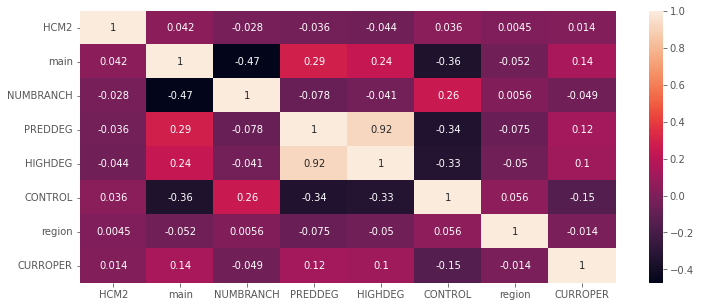

In [ ]:
matrix = bd3.corr()
sb.heatmap(matrix, annot=True)
plt.show

In [11]:
bd4=bd3.drop(columns=['PREDDEG'],)

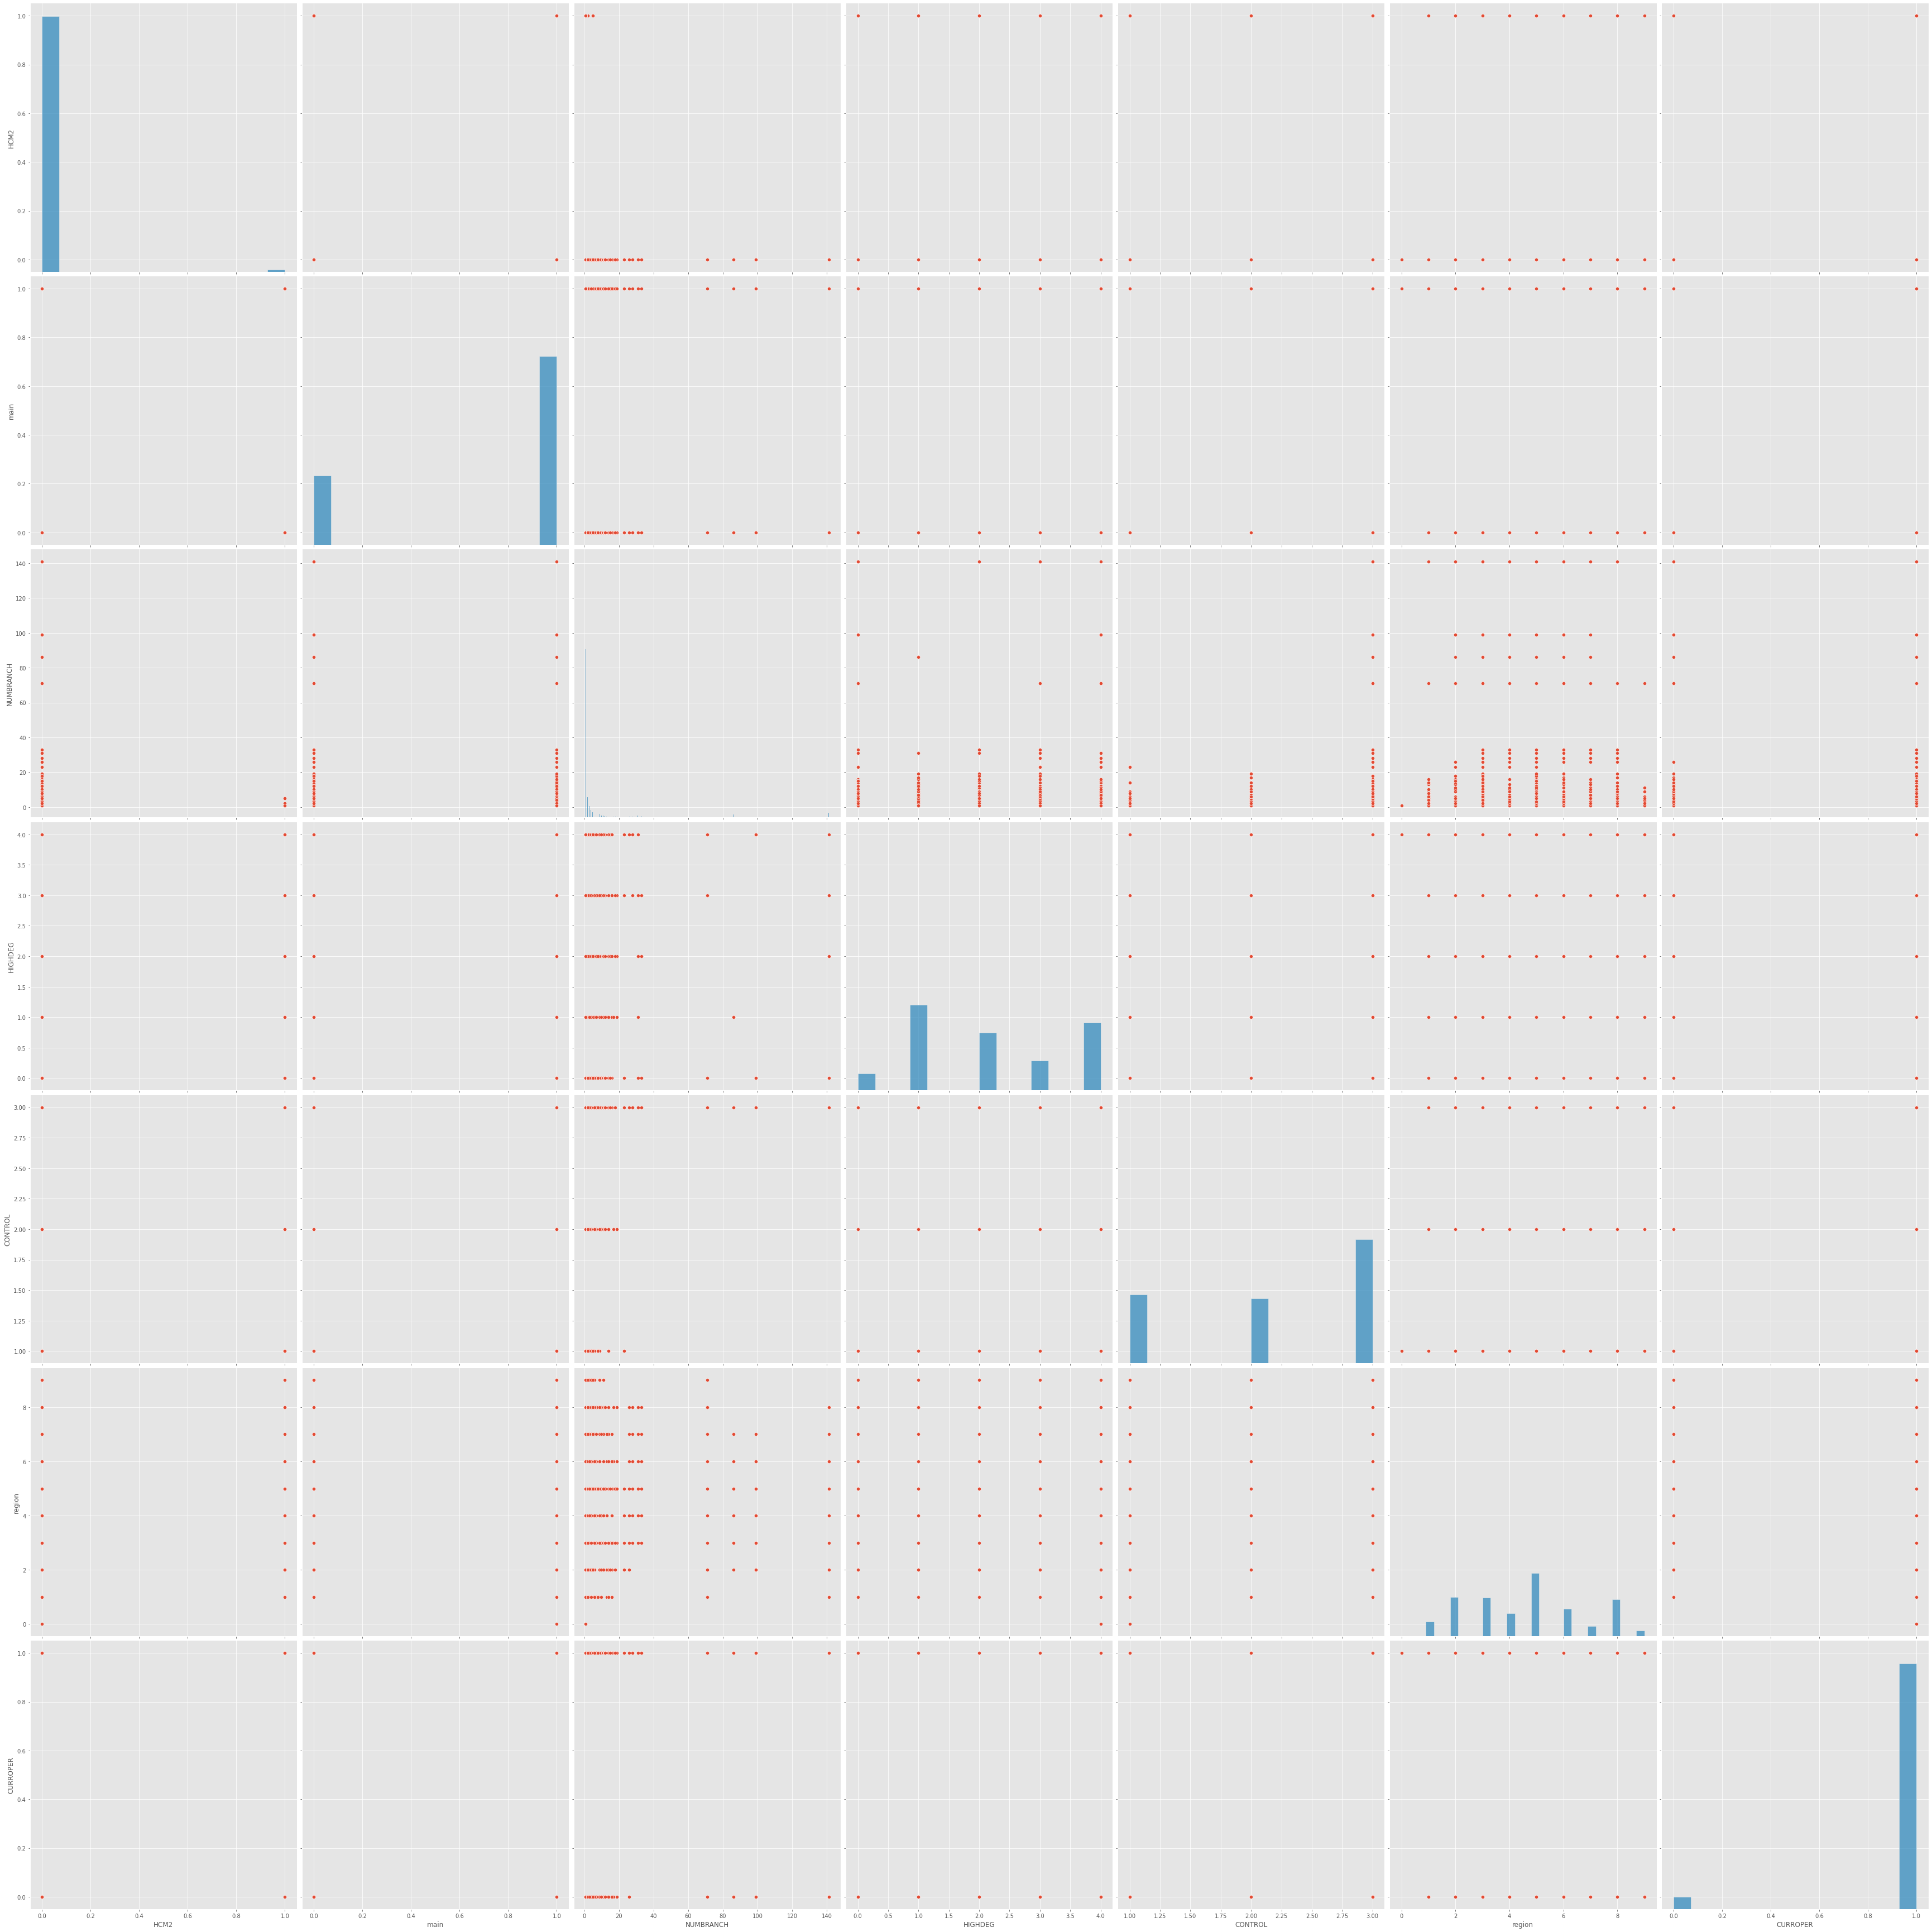

In [13]:
sb.pairplot(bd4.dropna(),
            height=7,
            vars=[
 'HCM2',
 'main',
 'NUMBRANCH',
 'HIGHDEG',
 'CONTROL',
 'region',
 'CURROPER'],
            kind='scatter')
plt.show()

In [14]:
semilla=bd4.drop(columns=[
 'NUMBRANCH'],)


In [15]:
semilla["HCM2"].replace(0, "not under investigation", inplace=True)
semilla["HCM2"].replace(1, "under investigation", inplace=True)
semilla["main"].replace(1, "Main campus", inplace=True)
semilla["main"].replace(0, "branch", inplace=True)
semilla["CURROPER"].replace(0, "closed", inplace=True)
semilla["CURROPER"].replace(1, "operating", inplace=True)
semilla["region"].replace(0, "U.S", inplace=True)
semilla["region"].replace(1, "New England", inplace=True)
semilla["region"].replace(2, "Mid East", inplace=True)
semilla["region"].replace(3, "Great Lakes", inplace=True)
semilla["region"].replace(4, "Plains", inplace=True)
semilla["region"].replace(5, "Southeast", inplace=True)
semilla["region"].replace(6, "Southwest", inplace=True)
semilla["region"].replace(7,"Rocky Mountains", inplace=True)
semilla["region"].replace(8, "Far West", inplace=True)
semilla["region"].replace(9, "Outlying Areas", inplace=True)

semilla["CONTROL"].replace(1, "Public", inplace=True)
semilla["CONTROL"].replace(2, "Private Non Profit", inplace=True)
semilla["CONTROL"].replace(3, "Private for profit", inplace=True)

semilla["HIGHDEG"].replace(0, "Non-degree-granting", inplace=True)
semilla["HIGHDEG"].replace(1, "Certificate degree", inplace=True)
semilla["HIGHDEG"].replace(2, "Associate degree", inplace=True)
semilla["HIGHDEG"].replace(3, "Bachelor's degree", inplace=True)
semilla["HIGHDEG"].replace(4, "Graduate degree", inplace=True)

In [18]:
semillas2=pd.get_dummies(semilla)

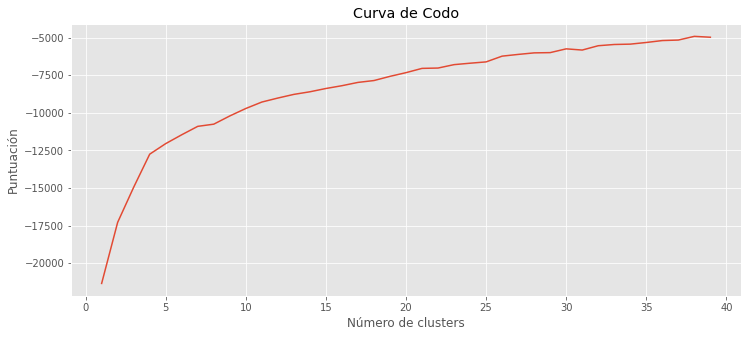

In [20]:
# Curva de Codo
Nc = range(1, 40)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(semillas2).score(semillas2) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación')
plt.title('Curva de Codo')
plt.show()


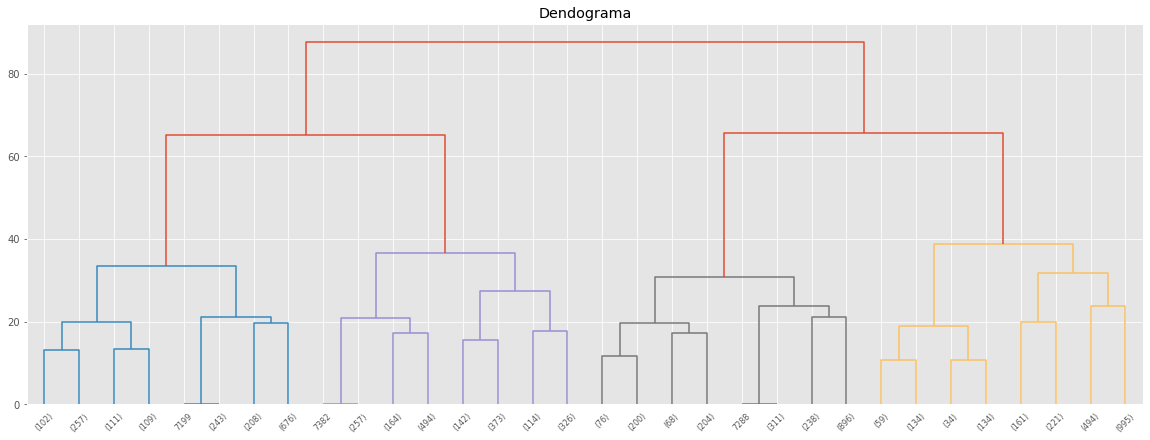

In [22]:
plt.figure(figsize=(20,7))
plt.title('Dendograma')
dend=sch.dendrogram(sch.linkage(semillas2,method='ward'),truncate_mode='level',p=4)

In [23]:
# nrefs es la cantidad de datos ("datasets") de referencia contra los que se va a comparar
def optimalK(data, nrefs=3, maxClusters=50):

    gaps = np.zeros((len(range(1, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters+1)):

        # guardara los resultados de dispersión de cada distribución simulada
        refDisps = np.zeros(nrefs)

        # Genera las muestras aleatorias indicadas con nrefs y ejecuta k-means
        # en cada bucle obteniendo los resultados de dispersión (inercia)
        # para cada conjunto generado.
        for i in range(nrefs):

            # Crea nuevo conjunto aleatorio de referencia
            # Se puede usar una semilla para tener reproducibilidad
            np.random.seed(0)
            randomReference = np.random.random_sample(size=data.shape)

            # se ajusta el modelo al conjunto de referencia
            km = KMeans(k)
            km.fit(randomReference)
            # se guarda la dispersión obtenida
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Se ajusta el modelo a los datos originales y se guarda su inercia
        km = KMeans(k)
        km.fit(data)

        origDisp = km.inertia_

        # Calcula el estadístico de gap para k clusters usando el promedio de
        # las dispersiones de los datos simulados y la dispersión de los datos originales.
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Guarda el estadístico de gap obtenido en este bucle.
        gaps[gap_index] = gap

        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    # Selecciona el "primer máximo" de los estadísticos obtenidos y devuelve
    # su respectivo número de clusters
    for i in range(0, len(gaps)-1):
      if gaps[i+1] <= gaps[i]:
        return (i+1, resultsdf)
    return (len(gaps), resultsdf)
    #retorna (gaps.argmax() + 1, resultsdf)  # se le suma 1 porque el indice de 0 significa 1 cluster es optimo, indice 2 = 3 clusters son optimos

In [24]:
k, gapdf = optimalK (semillas2, nrefs=5, maxClusters=50)
print('La cantidad óptima de clusters es: ', k)

La cantidad óptima de clusters es:  40


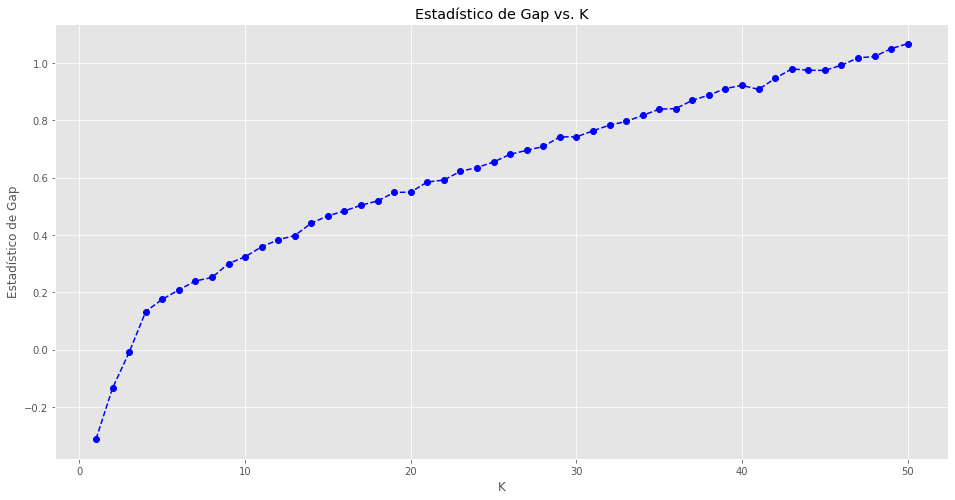

In [26]:
plt.figure(figsize=(16,8))
plt.plot(gapdf['clusterCount'], gapdf['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Estadístico de Gap');
plt.title('Estadístico de Gap vs. K');

In [36]:
# Aquí se muestra un arrays donde se clasifican los datos en los 3 clusters seleccionados del dendograma.
from sklearn.cluster import AgglomerativeClustering
cluster=AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
ayuda=cluster.fit(bd4)
labels_2D=ayuda.labels_

In [37]:
model=AgglomerativeClustering(n_clusters=4, linkage='ward')

data_fit_3=model.fit(semillas2)
lab_3c=data_fit_3.labels_


In [49]:

semillas2['Labels_3Clusters']=lab_3c
semillas2.describe()


,HCM2_not under investigation,HCM2_under investigation,main_Main campus,main_branch,HIGHDEG_Associate degree,HIGHDEG_Bachelor's degree,HIGHDEG_Certificate degree,HIGHDEG_Graduate degree,HIGHDEG_Non-degree-granting,CONTROL_Private Non Profit,...,region_New England,region_Outlying Areas,region_Plains,region_Rocky Mountains,region_Southeast,region_Southwest,region_U.S,CURROPER_closed,CURROPER_operating,Labels_3Clusters
count,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,...,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000,7804.000000
mean,0.991158,0.008842,0.731548,0.268452,0.222834,0.114813,0.332394,0.263455,0.066504,0.252307,...,0.057150,0.020759,0.087647,0.038826,0.244746,0.105331,0.000128,0.046515,0.953485,1.406971
std,0.093619,0.093619,0.443182,0.443182,0.416175,0.318816,0.471101,0.440535,0.249178,0.434364,...,0.232144,0.142584,0.282799,0.193193,0.429964,0.306999,0.011320,0.210610,0.210610,1.118476
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [41]:
#Grupo 0
print("GRUPO 0:")
is_G=semillas2.loc[:, 'Labels_3Clusters']==0
C3_G=semillas2[is_G]
df_0 = pd.DataFrame(C3_G.describe())
df_0

GRUPO 0:


,HCM2_not under investigation,HCM2_under investigation,main_Main campus,main_branch,HIGHDEG_Associate degree,HIGHDEG_Bachelor's degree,HIGHDEG_Certificate degree,HIGHDEG_Graduate degree,HIGHDEG_Non-degree-granting,CONTROL_Private Non Profit,...,region_New England,region_Outlying Areas,region_Plains,region_Rocky Mountains,region_Southeast,region_Southwest,region_U.S,CURROPER_closed,CURROPER_operating,Labels_3Clusters
count,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,...,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000,2232.0,2232.000000,2232.000000,2232.0
mean,0.999552,0.000448,0.073477,0.926523,0.195789,0.143817,0.316308,0.128136,0.215950,0.116487,...,0.042115,0.022849,0.078405,0.036738,0.258513,0.129928,0.0,0.162186,0.837814,0.0
std,0.021167,0.021167,0.260976,0.260976,0.396895,0.350983,0.465139,0.334316,0.411572,0.320880,...,0.200896,0.149457,0.268868,0.188161,0.437915,0.336300,0.0,0.368704,0.368704,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.0
50%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.0
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0


In [48]:
#Grupo 1
print("GRUPO 1:")
is_G=semillas2.loc[:, 'Labels_3Clusters']==1
C3_G=semillas2[is_G]
df_1 = pd.DataFrame(C3_G.describe())
df_1

GRUPO 1:


,HCM2_not under investigation,HCM2_under investigation,main_Main campus,main_branch,HIGHDEG_Associate degree,HIGHDEG_Bachelor's degree,HIGHDEG_Certificate degree,HIGHDEG_Graduate degree,HIGHDEG_Non-degree-granting,CONTROL_Private Non Profit,...,region_New England,region_Outlying Areas,region_Plains,region_Rocky Mountains,region_Southeast,region_Southwest,region_U.S,CURROPER_closed,CURROPER_operating,Labels_3Clusters
count,1871.0,1871.0,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.0,1871.0,...,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.000000,1871.0,1871.0,1871.0
mean,1.0,0.0,0.988242,0.011758,0.491716,0.053982,0.175307,0.278995,0.0,0.0,...,0.052913,0.012827,0.097274,0.042223,0.283271,0.119188,0.000534,0.0,1.0,1.0
std,0.0,0.0,0.107826,0.107826,0.500065,0.226042,0.380331,0.448625,0.0,0.0,...,0.223919,0.112559,0.296410,0.201152,0.450707,0.324096,0.023119,0.0,0.0,0.0
min,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0
25%,1.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0
50%,1.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0
75%,1.0,0.0,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.0,1.0
max,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0,1.0


In [46]:
#Grupo 2
print("GRUPO 2:")
is_G=semillas2.loc[:, 'Labels_3Clusters']==2
C3_G=semillas2[is_G]
df_2 = pd.DataFrame(C3_G.describe())
df_2

GRUPO 2:


,HCM2_not under investigation,HCM2_under investigation,main_Main campus,main_branch,HIGHDEG_Associate degree,HIGHDEG_Bachelor's degree,HIGHDEG_Certificate degree,HIGHDEG_Graduate degree,HIGHDEG_Non-degree-granting,CONTROL_Private Non Profit,...,region_New England,region_Outlying Areas,region_Plains,region_Rocky Mountains,region_Southeast,region_Southwest,region_U.S,CURROPER_closed,CURROPER_operating,Labels_3Clusters
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.0,1994.0,1994.0,1994.0
mean,0.965898,0.034102,0.997492,0.002508,0.153460,0.057172,0.726680,0.060181,0.002508,0.009529,...,0.045135,0.027583,0.073721,0.056169,0.229689,0.110832,0.0,0.0,1.0,2.0
std,0.181538,0.181538,0.050025,0.050025,0.360521,0.232228,0.445776,0.237881,0.050025,0.097173,...,0.207653,0.163815,0.261382,0.230305,0.420738,0.314003,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,2.0
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,2.0
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,2.0
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,2.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.0,2.0


In [47]:
#Grupo 3
print("GRUPO 3:")
is_G=semillas2.loc[:, 'Labels_3Clusters']==3
C3_G=semillas2[is_G]
df_3 = pd.DataFrame(C3_G.describe())
df_3

GRUPO 3:


,HCM2_not under investigation,HCM2_under investigation,main_Main campus,main_branch,HIGHDEG_Associate degree,HIGHDEG_Bachelor's degree,HIGHDEG_Certificate degree,HIGHDEG_Graduate degree,HIGHDEG_Non-degree-granting,CONTROL_Private Non Profit,...,region_New England,region_Outlying Areas,region_Plains,region_Rocky Mountains,region_Southeast,region_Southwest,region_U.S,CURROPER_closed,CURROPER_operating,Labels_3Clusters
count,1707.0,1707.0,1707.0,1707.0,1707.000000,1707.000000,1707.000000,1707.000000,1707.000000,1707.000000,...,1707.000000,1707.000000,1707.000000,1707.000000,1707.000000,1707.000000,1707.0,1707.000000,1707.000000,1707.0
mean,1.0,0.0,1.0,0.0,0.044523,0.210896,0.065026,0.660808,0.018746,0.990041,...,0.095489,0.018746,0.105448,0.017575,0.202109,0.051552,0.0,0.000586,0.999414,3.0
std,0.0,0.0,0.0,0.0,0.206313,0.408064,0.246645,0.473574,0.135668,0.099326,...,0.293976,0.135668,0.307220,0.131438,0.401691,0.221186,0.0,0.024204,0.024204,0.0
min,1.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.0
25%,1.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,3.0
50%,1.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,3.0
75%,1.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,3.0
max,1.0,0.0,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,3.0
